_What are is our hypothesis?_
1. Mortality rates will be different in areas of different treatment.
2. Mortality rates will be different over different landforms.
3. Recovery will occur at different rates on different landforms.
    a. Ridges and dryer slopes will recover more quickly than valleys under after severe fire?


_What do we know about the problem before observing any data?_  

_What conclusions can we draw from data given our prior knowledge?_

_Do these conclusions make sense?_


Joint density function of a tree being dead and a treatment:    
$p_{\theta}(\mathbf{x}, \mathbf{z}) = p_{\theta}(\mathbf{z})p(\mathbf{x}|\mathbf{z})$ 



In [1]:
from pathlib import Path
from joblib import Parallel, delayed

import pandas as pd
import geopandas as gpd
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings



/home/michael/TreeMortality/venvs/pyro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

## Load and prepare data
In this section we will read the stored predictions then draw $n$ samples from a _classification probability distribution_ for each of the $m$ crowns in the datset.  The mean of the prediction probability distribution will be the prediction probability from the RF model.  The standard deviation we be the value determined in `src/mortality_classification.ipynb`.  Once each crown has a classification probability distribution, they will be joined into an $m\times n$ array. 
$
[[x_{0\_0}, x_{0\_1}, ..., x_{0\_n}],\\
[x_{1\_1}, x_{1\_1}, ..., x_{1\_n}],\\
[\dots],\\
[x_{m\_1}, x_{m\_1}, ..., x_{m\_n}]]\\
$
where each row (of length $n$) corresponds to the observations for a single crown, and each column (of length $m$) corresponds to a _sample population_ of living and dead crowns.

In [3]:
# paths
helena_path = Path.cwd().parent / 'data' / 'helena'
pred_path = helena_path / 'predictions.parquet'
img_dir = Path('/home/michael/thesis/images')

# set seed for reproducibility
pyro.set_rng_seed(1234)

# function to return samples
def pred_model(μ, σ, sample_shape):
    return dist.Normal(μ, σ).sample(sample_shape=sample_shape)

In [4]:
# read the predictions to df, and add std column
pred_probs = gpd.read_parquet(pred_path).set_index('UniqueID')
pred_probs['sigma'] = 0.3348311848324811

In the cell below we define function to create populations of crowns, then summarize them by percentage of crowns which are dead. 

In [5]:
# processors for Parallel (-1 --> use all )
n_jobs = -1

def get_dead_percentages(samples, i):
    '''Returns percentage of crown predictions in colum i that are dead'''
    alive = (
        100
        * np.clip(samples, 0, 1).round().astype(int)[:, i].sum()
        / samples.shape[0]
    )
    
    return 100 - alive


def make_df_of_death(preds, draws=256):
    '''
    Returns Pandas DataFrame of percentages of crowns which are
    modeled as dead based the RF model predictions and sigma as
    found in mortality_clasification.ipynb.
    
    params:
        preds - Pandas DataFrame with prediction probabilities for each year.
        draws - Number of model draws to perform. 
    '''
    # get the names of columns containing predictions
    pred_cols = [c for c in preds.columns if 'pred_' in c]

    # sigma is the same for all
    sigma = torch.Tensor(preds.sigma.values)

    # empty df for results
    results = pd.DataFrame()

    for col in pred_cols:
        # get predictions as means
        mu = torch.Tensor(preds[col].values)
        
        # draw 256 samples per row
        samples = np.array(
            pred_model(
                mu,
                sigma,
                (draws,)
            )
        ).T
        
        dead_sums = Parallel(n_jobs=n_jobs)(
            delayed(get_dead_percentages)(samples, i)
            for i
            in range(samples.shape[1])
        )
        
        results[col.split('_')[1]] = dead_sums
        
    return results
        

In [6]:

dead = make_df_of_death(pred_probs)
dead.head()

,2018,2020,2022
0,48.628039,40.049266,59.408804
1,48.587341,40.310592,59.732248
2,48.557352,40.147799,59.869337
3,48.313163,40.094249,59.678698
4,48.251044,40.173503,59.515904


Each row in the DataFrame above contains an estimate for the percentage of crowns that are dead in each year corresponding to a sample population.

Text(0.5, 1.0, 'Percentage of Crowns Which Are Dead')

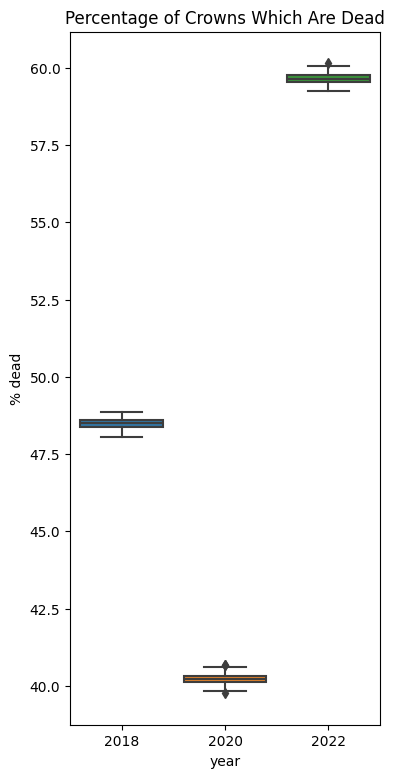

In [7]:
df_melted = dead.melt()
df_melted.columns = ['year', '% dead']
fig, ax = plt.subplots(1, 1, figsize=(4,9))
ax = sns.boxplot(
    data=df_melted,
    x='year',
    y='% dead',
)

ax.set_title('Percentage of Crowns Which Are Dead')

Boxplot showing the percentage of crowns which are dead for each year. Boxes show the distribution of results from populations (n=256) simulated using draws from the classification probability distributions of each crown.

In [8]:
def find_credible_interval(df, column_name, credible_mass=0.95):
    '''Returns credible interval bounds of df column.'''
    sorted_samples = np.sort(df[column_name].values)
    n_samples = len(sorted_samples)    
    # find index increment for credible mass
    ci_idx_inc = int(np.ceil(credible_mass * n_samples))
    # calculate the number of credible intervals
    n_ci = n_samples - ci_idx_inc
    # calculate width of each potential interval
    ci_width = sorted_samples[ci_idx_inc:] - sorted_samples[:n_ci]
    # find narrowest interval
    best_idx = np.argmin(ci_width)
    # get lower and upper bounds of credible interval
    hdi_min = sorted_samples[best_idx]
    hdi_max = sorted_samples[best_idx + ci_idx_inc]
    
    return hdi_min, hdi_max


In [9]:
dead['Annual Mortality 2018-2020'] = (dead['2018'] - dead['2020']) / 2
dead['Annual Mortality 2020-2022'] = (dead['2020'] - dead['2022']) / 2

credible_intervals = np.array([
    find_credible_interval(dead, col) for col in ['2018', '2020', '2022']
])

credible_intervals_mortality = np.array([
    find_credible_interval(dead, col) for col in ['Annual Mortality 2018-2020', 'Annual Mortality 2020-2022']
])

credible_lines_18_20 = dead[['2018', '2020']][
    (dead['Annual Mortality 2018-2020'] >=  credible_intervals_mortality[0, 0]) &
    (dead['Annual Mortality 2018-2020'] <=  credible_intervals_mortality[0, 1])
    ].T

credible_lines_20_22 = dead[['2020', '2022']][
    (dead['Annual Mortality 2020-2022'] >=  credible_intervals_mortality[1, 0]) &
    (dead['Annual Mortality 2020-2022'] <=  credible_intervals_mortality[1, 1])
    ].T



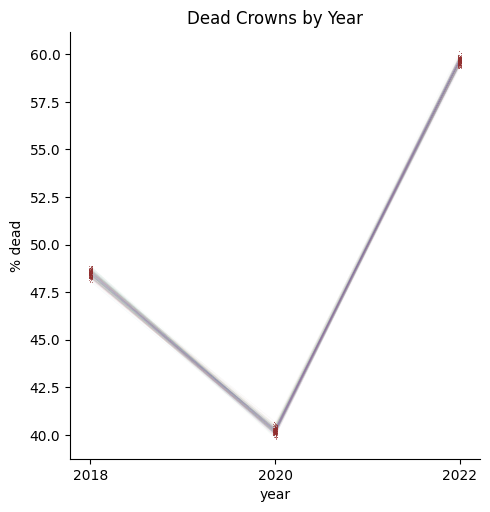

In [10]:
a = sns.catplot(
    data=df_melted,
    x='year',
    y='% dead',
    jitter=0.01,
    marker='.',
    size=1,
    color='r'
)

lw = 0.03

b = sns.lineplot(
    data=credible_lines_18_20,
    color='grey',
    linewidth=lw,
    alpha=0.5
)

c = sns.lineplot(
    data=credible_lines_20_22,
    color='grey',
    linewidth=lw,
    alpha=0.5
)

plt.legend('', frameon=False);
plt.title('Dead Crowns by Year')

plt.savefig(img_dir / 'helena_full_pop_scatter.png')

In [11]:
ci = credible_intervals.round(2)
cim = credible_intervals_mortality.round(2)



print(
    f'''
    Plot showing distributions of the percentages of crowns which are dead for each
    year (red points) and lines (grey) falling within the 95\% credible interval of annual mortality.
    The 95% credible intervals for percent of trees dead in: 2018$\\aprox${list(ci[0])},
    2020$\\aprox${list(ci[1])}, 2022$\\aprox${list(ci[2])}. The 95% credible intervals of annual
    mortality trends are: {cim[0]} for the period from 2018 to 2020, and {cim[1]} (recovery) for the period
    from 2020 to 2022. Data comes from the distribution of results from populations (n=256)
    simulated using draws from the classification probability distributions
    of each crown.
    '''
)



    Plot showing distributions of the percentages of crowns which are dead for each
    year (red points) and lines (grey) falling within the 95\% credible interval of annual mortality.
    The 95% credible intervals for percent of trees dead in: 2018$\aprox$[48.2, 48.85],
    2020$\aprox$[39.89, 40.51], 2022$\aprox$[59.31, 59.92]. The 95% credible intervals of annual
    mortality trends are: [3.93 4.39] for the period from 2018 to 2020, and [-9.93 -9.53] (recovery) for the period
    from 2020 to 2022. Data comes from the distribution of results from populations (n=256)
    simulated using draws from the classification probability distributions
    of each crown.
    


## Statistical difference between treatments.

+ find 95% credible interval for each treatment, landform, and treatment/landform
+ see if they overlap

This is a variation on permutatuion testing. See:
Cobb, George W. "The introductory statistics course: A Ptolemaic curriculum?." Technology innovations in statistics education 1.1 (2007).

### Make samples
In the cell below we make a dataframe containing 256 samples from the classification probability distribution of each crown. Each sample is an array of 0 or 1 integers denoting dead or living tree crowns.

In [12]:
#def pred_model():
    

def make_pop_df(preds, draws=256):
    '''
    Returns Pandas DataFrame of samples from crowns which are
    classified based the RF model predictions and sigma as
    found in mortality_clasification.ipynb.
    
    params:
        preds - Pandas DataFrame with prediction probabilities for each year.
        draws - Number of model draws to perform. 
    '''
    # make a df to return
    cols_dict = {
        c: preds[c]
        for c in[
            'treatment',
            'geomorph_100',
            'geomorph_250',
            'geomorph_500',
            'geomorph_1000',
            'geomorph_2000'
        ]
    }
    out_df = pd.DataFrame().assign(**cols_dict)
    
    # get the names of columns containing predictions
    pred_cols = [c for c in preds.columns if 'pred_' in c]

    # sigma is the same for all
    sigma = torch.Tensor(preds.sigma.values)

    for col in pred_cols:
        # get predictions as means
        mu = torch.Tensor(preds[col].values)
        
        # draw 256 per row
        sample = list(np.round(
            np.clip(
                np.array(
                    pred_model(
                        mu,
                        sigma,
                        (draws,)
                    ).T
                ),
                0,
                1
            )
            ).astype(int)
        )
        
        
        
        new_col = 'sample_' + col.split('_')[-1]
        out_df[new_col] = sample
        
    return out_df

# make sample df and check
sample_df = make_pop_df(pred_probs)   
print('sample_df.shape:', sample_df.shape)
print('sample shape:', sample_df.sample_2018.iloc[0].shape)
print('sample_df columns:')
_ = [print(f'\t{c}') for c in sample_df.columns]
print('sample_df index values(head):')
_ = [print(f'\t{i}') for i in sample_df.head().index]


sample_df.shape: (46685, 9)
sample shape: (256,)
sample_df columns:
	treatment
	geomorph_100
	geomorph_250
	geomorph_500
	geomorph_1000
	geomorph_2000
	sample_2018
	sample_2020
	sample_2022
sample_df index values(head):
	10N_483827_4524602
	10N_483828_4512551
	10N_483828_4514248
	10N_483829_4514263
	10N_483830_4510126


Alive and dead


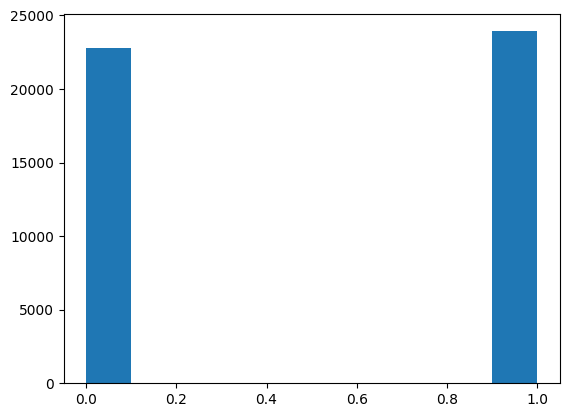

In [13]:
sample = np.stack(sample_df.sample_2018.values)[:, 0]
plt.hist(
    [sample]
    );

print('Alive and dead')

### Difference between treatments
Now we will look at histograms and credible intervals to determine difference between groups of crowns.

In [14]:
sample_df.treatment.unique()

array([ 3,  0, 12, 15])

In [17]:
def get_treatment_obs(y):
    '''Returns dict of treatment observations for year y.'''
    # dict mapping codes to meanings
    tr_codes = {
        0: 'unburned | unburned',
        3: 'unburned | high',
        12: 'high | unburned',
        15: 'high | high'
    }

    # empty dict for observations
    treatment_obs = {}
    # list of treatments
    treatments = list(tr_codes.keys())

    # get observations for all treatments
    all = np.stack(sample_df[f'sample_{y}'].values)
    treatment_obs['all treatments'] = Parallel(n_jobs=n_jobs)(
        delayed(get_dead_percentages)(all, i)
        for i
        in range(all.shape[1])
    )
    # get observations for each treatment
    for t in treatments:
        tr = np.stack(sample_df[sample_df.treatment == t][f'sample_{y}'].values)
        treatment_obs[tr_codes[t]] = Parallel(n_jobs=n_jobs)(
        delayed(get_dead_percentages)(tr, i)
        for i
        in range(tr.shape[1])
    )
        
    return treatment_obs


In [46]:
gs

GridSpec(2, 3)

LaTeX version:

    Shows histograms of percent dead in simulated tree populations for the year 2022. Clockwise from left: a) all treatments show in same axis; b) Closeup of the unburned treatments with 95\% HDIs (unburned | unburned: [22.94, 24.10], unburned | high:[79.31, 80.52]); c) Closeup of the high severity treatments with 95\% HDIs (high | unburned: [71.56, 72.63], high | high:[80.23, 82.95])  Note, that in 2018 the Monument fire had not yet happened, so all treatment histograms are either unburnt, or burnt at high severity once.  It is unexpected, given this fact, that the two unburned treatments are significantly different from one another, and the two high severity treatments are different from one another.
    

Version for reading here:

    Shows histograms of percent dead in simulated tree populations for the year 2022.
    Clockwise from left: a) all treatments show in same axis; b) Closeup of the unburned
    treatments with 95\% credible intervals (unburned | unburned

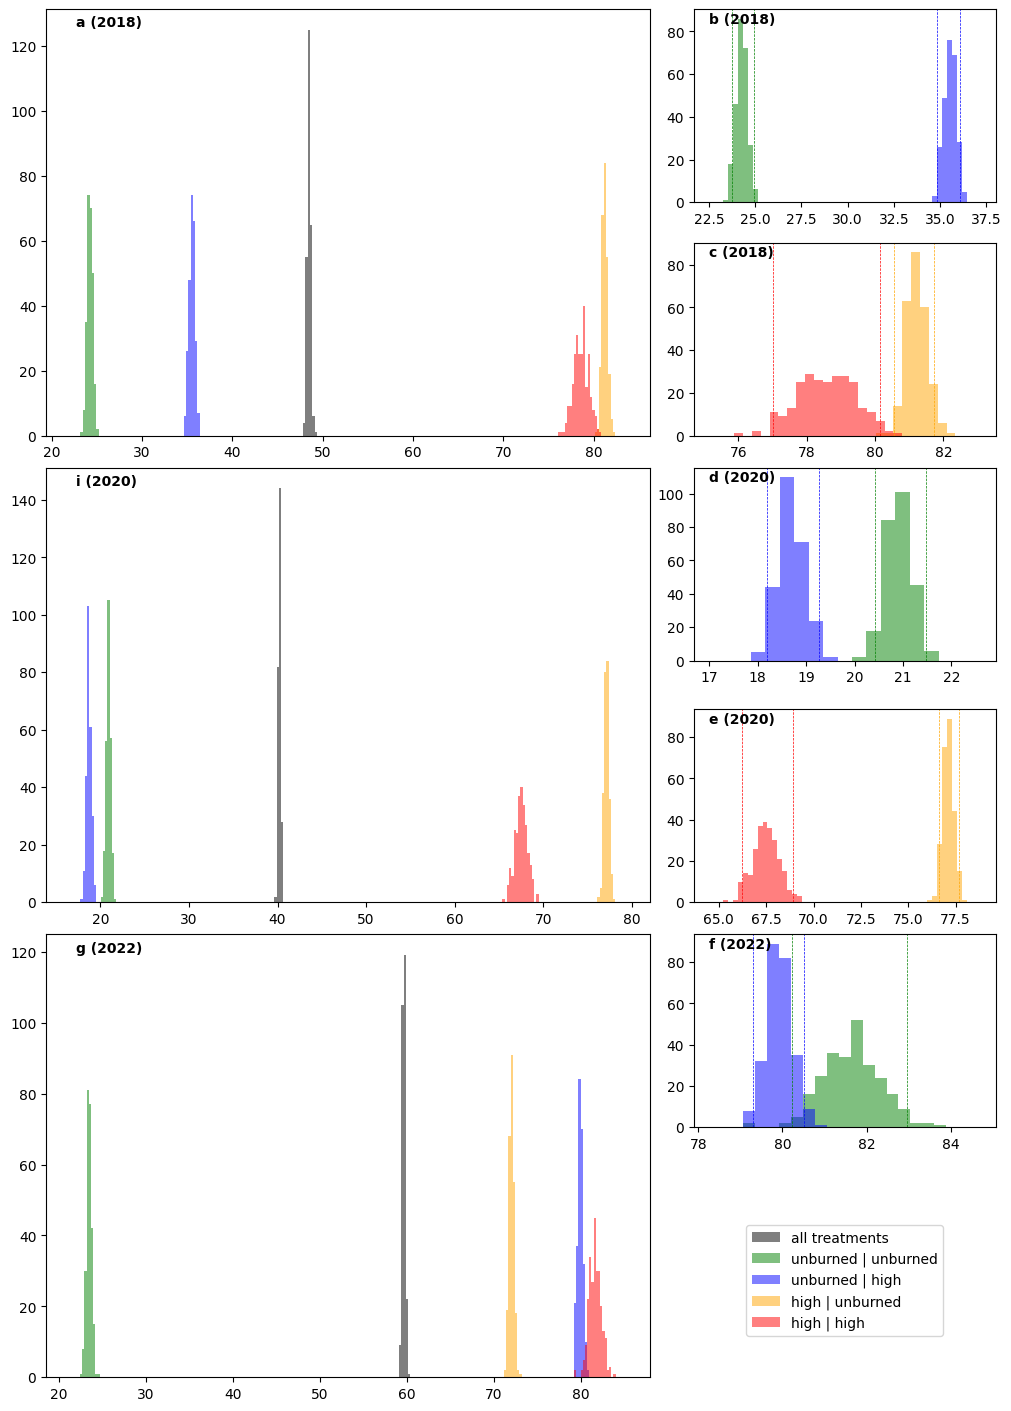

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [76]:

        
fig = plt.figure(layout='constrained', figsize=(10, 14))
gs = GridSpec(6, 3, figure=fig)

ax1 = fig.add_subplot(gs[:2, :2])
ax2 = fig.add_subplot(gs[0, -1])
ax3 = fig.add_subplot(gs[1, -1])
ax4 = fig.add_subplot(gs[2:4, :2])
ax5 = fig.add_subplot(gs[2, -1])
ax6 = fig.add_subplot(gs[3, -1])
ax7 = fig.add_subplot(gs[4:6, :2])
ax8 = fig.add_subplot(gs[4, -1])
ax9 = fig.add_subplot(gs[5, -1])

y = '2018'
# get the treatment observations
treatment_obs = get_treatment_obs(y)
treatment_obs_df = pd.DataFrame.from_dict(treatment_obs)

# fing 95% HDIs
tr_creds = {
    c: find_credible_interval(treatment_obs_df, c)
    for c in treatment_obs_df.columns
    }

def get_min_min_and_max_max(obs_dict):
    '''gets min and mx from all values in dict'''
    minimum = min([min(v) for v in obs_dict.values()])
    maximum = max([max(v) for v in obs_dict.values()])
    return minimum, maximum 

mn, mx = get_min_min_and_max_max(treatment_obs)
mn, mx = mn - 1, mx + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )

colors = ['k', 'g', 'b', 'orange', 'red']

for i, (key, val) in enumerate(treatment_obs.items()):
    ax1.hist(val, bins, alpha=0.5, color=colors[i], label=key);
ax1.legend(loc='upper right', fontsize='7.5');

mn = min(
    treatment_obs_df['unburned | unburned'].min(),
    treatment_obs_df['unburned | high'].min()
) -1
mx = max(
    treatment_obs_df['unburned | unburned'].max(),
    treatment_obs_df['unburned | high'].max()
) + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )
colors = ['g', 'b']

for i, col in enumerate(['unburned | unburned', 'unburned | high']):
    ax2.hist(treatment_obs_df[col].values, bins, alpha=0.5, color=colors[i], label=col);
    for x in tr_creds[col]:
        ax2.axvline(x, **{
            'color': colors[i],
            'linestyle': 'dashed',
            'linewidth': 0.5
            })
	
mn = min(
    treatment_obs_df['high | unburned'].min(),
    treatment_obs_df['high | high'].min()
) -1
mx = max(
    treatment_obs_df['high | unburned'].max(),
    treatment_obs_df['high | high'].max()
) + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )
colors = ['orange', 'r']

for i, col in enumerate(['high | unburned', 'high | high']):
    ax3.hist(treatment_obs_df[col].values, bins, alpha=0.5, color=colors[i], label=col);
    for x in tr_creds[col]:
        ax3.axvline(x, **{
            'color': colors[i],
            'linestyle': 'dashed',
            'linewidth': 0.5
            })
        
ax1.annotate('a (2018)', (0.05, 0.96), xycoords='axes fraction', weight='bold');
ax2.annotate('b (2018)', (0.05, 0.93), xycoords='axes fraction', weight='bold');
ax3.annotate('c (2018)', (0.05, 0.93), xycoords='axes fraction', weight='bold');

uu18 = tr_creds['unburned | unburned']
uh18 = tr_creds['unburned | high']
hu18 = tr_creds['high | unburned']
hh18 = tr_creds['high | high']

# -----

y = '2020'
# get the treatment observations
treatment_obs = get_treatment_obs(y)
treatment_obs_df = pd.DataFrame.from_dict(treatment_obs)

# fing 95% HDIs
tr_creds = {
    c: find_credible_interval(treatment_obs_df, c)
    for c in treatment_obs_df.columns
    }

def get_min_min_and_max_max(obs_dict):
    '''gets min and mx from all values in dict'''
    minimum = min([min(v) for v in obs_dict.values()])
    maximum = max([max(v) for v in obs_dict.values()])
    return minimum, maximum 

mn, mx = get_min_min_and_max_max(treatment_obs)
mn, mx = mn - 1, mx + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )

colors = ['k', 'g', 'b', 'orange', 'red']

fig = plt.figure(layout='constrained')
gs = GridSpec(2, 3, figure=fig)

for i, (key, val) in enumerate(treatment_obs.items()):
    ax4.hist(val, bins, alpha=0.5, color=colors[i], label=key);
ax4.legend(loc='upper right', fontsize='7.5');

mn = min(
    treatment_obs_df['unburned | unburned'].min(),
    treatment_obs_df['unburned | high'].min()
) -1
mx = max(
    treatment_obs_df['unburned | unburned'].max(),
    treatment_obs_df['unburned | high'].max()
) + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )
colors = ['g', 'b']

for i, col in enumerate(['unburned | unburned', 'unburned | high']):
    ax5.hist(treatment_obs_df[col].values, bins, alpha=0.5, color=colors[i], label=col);
    for x in tr_creds[col]:
        ax5.axvline(x, **{
            'color': colors[i],
            'linestyle': 'dashed',
            'linewidth': 0.5
            })
        
mn = min(
    treatment_obs_df['high | unburned'].min(),
    treatment_obs_df['high | high'].min()
) -1
mx = max(
    treatment_obs_df['high | unburned'].max(),
    treatment_obs_df['high | high'].max()
) + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )
colors = ['orange', 'r']

for i, col in enumerate(['high | unburned', 'high | high']):
    ax6.hist(treatment_obs_df[col].values, bins, alpha=0.5, color=colors[i], label=col);
    for x in tr_creds[col]:
        ax6.axvline(x, **{
            'color': colors[i],
            'linestyle': 'dashed',
            'linewidth': 0.5
            })
        
ax4.annotate('i (2020)', (0.05, 0.96), xycoords='axes fraction', weight='bold');
ax5.annotate('d (2020)', (0.05, 0.93), xycoords='axes fraction', weight='bold');
ax6.annotate('e (2020)', (0.05, 0.93), xycoords='axes fraction', weight='bold');

uu20 = tr_creds['unburned | unburned']
uh20 = tr_creds['unburned | high']
hu20 = tr_creds['high | unburned']
hh20 = tr_creds['high | high']

# -----

y = '2022'
# get the treatment observations
treatment_obs = get_treatment_obs(y)
treatment_obs_df = pd.DataFrame.from_dict(treatment_obs)

# fing 95% HDIs
tr_creds = {
    c: find_credible_interval(treatment_obs_df, c)
    for c in treatment_obs_df.columns
    }

def get_min_min_and_max_max(obs_dict):
    '''gets min and mx from all values in dict'''
    minimum = min([min(v) for v in obs_dict.values()])
    maximum = max([max(v) for v in obs_dict.values()])
    return minimum, maximum 

mn, mx = get_min_min_and_max_max(treatment_obs)
mn, mx = mn - 1, mx + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )

colors = ['k', 'g', 'b', 'orange', 'red']

fig = plt.figure(layout='constrained')
gs = GridSpec(2, 3, figure=fig)

for i, (key, val) in enumerate(treatment_obs.items()):
    ax7.hist(val, bins, alpha=0.5, color=colors[i], label=key);
ax7.legend(loc='upper right', fontsize='7.5');

mn = min(
    treatment_obs_df['high | high'].min(),
    treatment_obs_df['unburned | high'].min()
) -1
mx = max(
    treatment_obs_df['high | high'].max(),
    treatment_obs_df['unburned | high'].max()
) + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )
colors = ['r', 'b']

for i, col in enumerate(['high | high', 'unburned | high']):
    ax8.hist(treatment_obs_df[col].values, bins, alpha=0.5, color=colors[i], label=col);
    for x in tr_creds[col]:
        ax8.axvline(x, **{
            'color': colors[i],
            'linestyle': 'dashed',
            'linewidth': 0.5
            })
        
mn = min(
    treatment_obs_df['high | unburned'].min(),
    treatment_obs_df['high | high'].min()
) -1
mx = max(
    treatment_obs_df['high | unburned'].max(),
    treatment_obs_df['high | high'].max()
) + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )
colors = ['orange', 'r']

ax7.annotate('g (2022)', (0.05, 0.96), xycoords='axes fraction', weight='bold');
ax8.annotate('f (2022)', (0.05, 0.93), xycoords='axes fraction', weight='bold');

#make stand alone legend
hand, lab = ax1.get_legend_handles_labels()
ax9.set_xticks([])
ax9.set_yticks([])
ax9.set_frame_on(False)
ax9.legend(hand, lab, loc='center')

# hide other legends
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.legend().set_visible(False)

plt.savefig(img_dir / f'dead_by_treatment.png')

uu22 = tr_creds['unburned | unburned']
uh22 = tr_creds['unburned | high']
hu22 = tr_creds['high | unburned']
hh22 = tr_creds['high | high']


print('LaTeX version:')
print(
    f'''
    Shows histograms of percent dead in simulated tree populations for the year 2018, 2020, and 2022. Clockwise from left: a) all treatments for the year 2018 shown together; b) Closeup of the unburned treatments for 2018 with 95\% HDIs (unburned | unburned: [{uu18[0]:.2f}, {uu18[1]:.2f}], unburned | high:[{uh[0]:.2f}, {uh[1]:.2f}]); c) Closeup of the high severity treatments for 2018 with 95\% HDIs (high | unburned: [{hu[0]:.2f}, {hu[1]:.2f}], high | high:[{hh[0]:.2f}, {hh18[1]:.2f}]); d)  
    
    \n\nNote, that in 2018 the Monument fire had not yet happened, so all treatment histograms are either unburnt, or burnt at high severity once.  It is unexpected, given this fact, that the two unburned treatments are significantly different from one another, and the two high severity treatments are different from one another.
    '''
)
print('\nVersion for reading here:')
print(
    f'''
    
    '''
)

plt.show()

LaTeX version:

    Shows histograms of percent dead in simulated tree populations for the year 2020. Clockwise from left: a) all treatments show in same axis; b) Closeup of the unburned treatments with 95\% HDIs (unburned | unburned: [20.43, 21.48], unburned | high:[18.20, 19.26]); c) Closeup of the high severity treatments with 95\% HDIs (high | unburned: [76.61, 77.70], high | high:[66.20, 68.92])  Note, that in 2018 the Monument fire had not yet happened, so all treatment histograms are either unburnt, or burnt at high severity once.  It is unexpected, given this fact, that the two unburned treatments are significantly different from one another, and the two high severity treatments are different from one another.
    

Version for reading here:

    Shows histograms of percent dead in simulated tree populations for the year 2020.
    Clockwise from left: a) all treatments show in same axis; b) Closeup of the unburned
    treatments with 95\% credible intervals (unburned | unburned

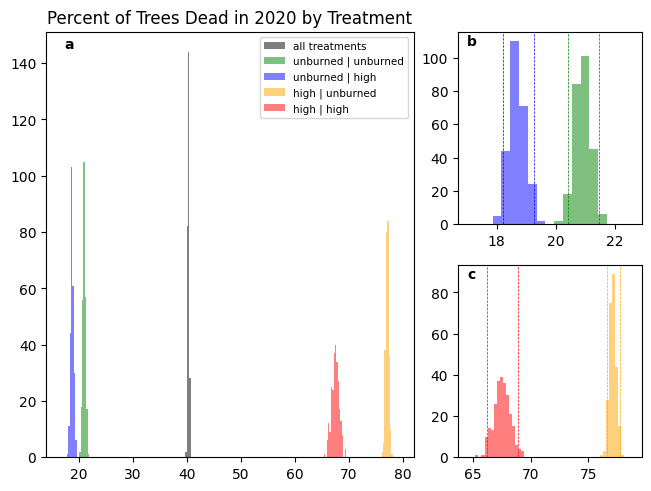

In [34]:
y = '2020'
# get the treatment observations
treatment_obs = get_treatment_obs(y)
treatment_obs_df = pd.DataFrame.from_dict(treatment_obs)

# fing 95% HDIs
tr_creds = {
    c: find_credible_interval(treatment_obs_df, c)
    for c in treatment_obs_df.columns
    }

def get_min_min_and_max_max(obs_dict):
    '''gets min and mx from all values in dict'''
    minimum = min([min(v) for v in obs_dict.values()])
    maximum = max([max(v) for v in obs_dict.values()])
    return minimum, maximum 

mn, mx = get_min_min_and_max_max(treatment_obs)
mn, mx = mn - 1, mx + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )

colors = ['k', 'g', 'b', 'orange', 'red']

fig = plt.figure(layout='constrained')
gs = GridSpec(2, 3, figure=fig)

ax4 = fig.add_subplot(gs[2:4, :2])
ax5 = fig.add_subplot(gs[2, -1])
ax6 = fig.add_subplot(gs[3, -1])

for i, (key, val) in enumerate(treatment_obs.items()):
    ax4.hist(val, bins, alpha=0.5, color=colors[i], label=key);
ax4.legend(loc='upper right', fontsize='7.5');
ax4.set_title(f'Percent of Trees Dead in {y} by Treatment');

mn = min(
    treatment_obs_df['unburned | unburned'].min(),
    treatment_obs_df['unburned | high'].min()
) -1
mx = max(
    treatment_obs_df['unburned | unburned'].max(),
    treatment_obs_df['unburned | high'].max()
) + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )
colors = ['g', 'b']

for i, col in enumerate(['unburned | unburned', 'unburned | high']):
    ax5.hist(treatment_obs_df[col].values, bins, alpha=0.5, color=colors[i], label=col);
    for x in tr_creds[col]:
        ax5.axvline(x, **{
            'color': colors[i],
            'linestyle': 'dashed',
            'linewidth': 0.5
            })
        
# -------
	
mn = min(
    treatment_obs_df['high | unburned'].min(),
    treatment_obs_df['high | high'].min()
) -1
mx = max(
    treatment_obs_df['high | unburned'].max(),
    treatment_obs_df['high | high'].max()
) + 1
bins = np.linspace(mn, mx, int(mx - mn) * 4 )
colors = ['orange', 'r']

for i, col in enumerate(['high | unburned', 'high | high']):
    ax6.hist(treatment_obs_df[col].values, bins, alpha=0.5, color=colors[i], label=col);
    for x in tr_creds[col]:
        ax6.axvline(x, **{
            'color': colors[i],
            'linestyle': 'dashed',
            'linewidth': 0.5
            })
        
ax4.annotate('a', (0.05, 0.96), xycoords='axes fraction', weight='bold');
ax5.annotate('b', (0.05, 0.93), xycoords='axes fraction', weight='bold');
ax6.annotate('c', (0.05, 0.93), xycoords='axes fraction', weight='bold');

plt.savefig(img_dir / f'dead_by_treatment_{y}.png')

uu = tr_creds['unburned | unburned']
uh = tr_creds['unburned | high']
hu = tr_creds['high | unburned']
hh = tr_creds['high | high']

print('LaTeX version:')
print(
    f'''
    Shows histograms of percent dead in simulated tree populations for the year {y}. Clockwise from left: a) all treatments show in same axis; b) Closeup of the unburned treatments with 95\% HDIs (unburned | unburned: [{uu[0]:.2f}, {uu[1]:.2f}], unburned | high:[{uh[0]:.2f}, {uh[1]:.2f}]); c) Closeup of the high severity treatments with 95\% HDIs (high | unburned: [{hu[0]:.2f}, {hu[1]:.2f}], high | high:[{hh[0]:.2f}, {hh[1]:.2f}])  Note, that in 2018 the Monument fire had not yet happened, so all treatment histograms are either unburnt, or burnt at high severity once.  It is unexpected, given this fact, that the two unburned treatments are significantly different from one another, and the two high severity treatments are different from one another.
    '''
)
print('\nVersion for reading here:')
print(
    f'''
    Shows histograms of percent dead in simulated tree populations for the year {y}.
    Clockwise from left: a) all treatments show in same axis; b) Closeup of the unburned
    treatments with 95\% credible intervals (unburned | unburned: [{uu[0]:.2f}, {uu[1]:.2f}],
    unburned | high:[{uh[0]:.2f}, {uh[1]:.2f}]); c) Closeup of the high severity treatments
    with 95\% credible intervals (high | unburned: [{hu[0]:.2f}, {hu[1]:.2f}],
    high | high:[{hh[0]:.2f}, {hh[1]:.2f}])  Note, that in 2018 the Monument fire had not yet
    happened, so all treatment histograms are either unburnt, or burnt at high severity once.
    It is unexpected, given this fact, that the two unburned treatments are significantly
    different from one another, and the two high severity treatments are different from one
    another.
    '''
)

